In [1]:
import librosa
import matplotlib as mpl
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
import tams_pr2_guzheng.utils as utils
import pandas as pd
import pickle as pkl
import seaborn as sns

from collections import Counter
from glob import glob
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from tams_pr2_guzheng.paths import RuckigPath
from IPython import display
from tqdm.auto import tqdm
#mpl.style.use('seaborn-v0_8')

%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u
%aimport tams_pr2_guzheng.utils

In [2]:
FOLDER = '/home/v4hn/ros/one/guzheng/data/active_safe_exploration/20230907 five repetitions'
FOLDER_NAME = FOLDER.split('/')[-1]
FILES=[f.split('/')[-1] for f in glob(f'{FOLDER}/*.json')]
FILES.sort()
FILES=FILES[:]
FILES_i = 0

Analyses = {}

FILES

['plucks_explore_fis4_inwards_20230907150000.json',
 'plucks_explore_fis4_inwards_20230907152154.json',
 'plucks_explore_fis4_inwards_20230907155117.json',
 'plucks_explore_fis4_inwards_20230907162727.json',
 'plucks_explore_fis4_inwards_20230907165613.json']

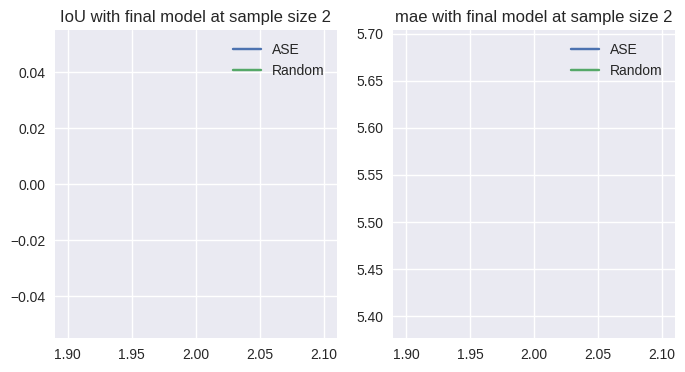

  0%|          | 0/276 [00:00<?, ?it/s]

max p_safe in samples: 0.9221983151814815
max p_safe in samples trained on 2 samples: 0.6238888894577088
0 samples are safe according to the GP trained on 2 samples of ASE
697 samples are safe according to the GP trained on all samples
697 samples are safe in union
max p_safe in samples: 0.9221983151814815
max p_safe in samples trained on 2 samples: 0.5732008227037537
0 samples are safe according to the GP trained on 2 samples of Random
697 samples are safe according to the GP trained on all samples
697 samples are safe in union
max p_safe in samples: 0.9221983151814815
max p_safe in samples trained on 3 samples: 0.6596360422539296
0 samples are safe according to the GP trained on 3 samples of ASE
697 samples are safe according to the GP trained on all samples
697 samples are safe in union
max p_safe in samples: 0.9221983151814815
max p_safe in samples trained on 3 samples: 0.5745074762649452
0 samples are safe according to the GP trained on 3 samples of Random
697 samples are safe acc

KeyboardInterrupt: 

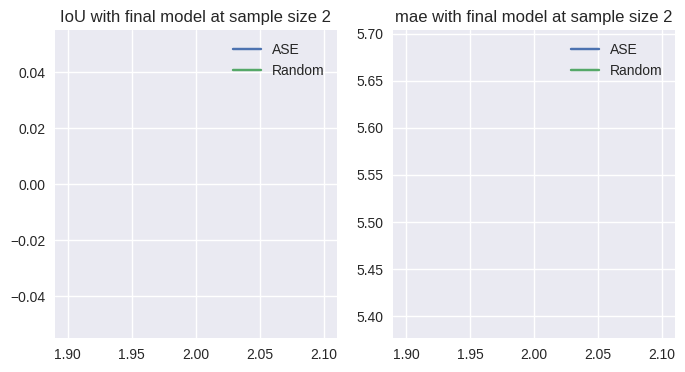

In [15]:
for D_FILE in FILES:
    D_NAME= D_FILE.split('.')[0]
    D= pd.read_json(f'{FOLDER}/{D_FILE}')
    DF= D[['string','keypoint_pos_y', 'string_position', 'detected_note', 'loudness', 'unexpected_onsets', 'min_distance', 'neighborhood_context']].copy()
    DF['safety_score'] = utils.score_safety(DF)
    DL = DF[DF['loudness'].notna()].copy()

    DF_test = DL.sample(frac= 0.1)
    DF.drop(DF_test.index, inplace= True)

    # prepare constants
    p_threshold_safe = 0.9
    # pred_error_threshold = 3.0

    string_len = DF['string_position'].max()

    if (D['pre_y'] < 0.0).any():
        keypoint_pos_y_limits = np.array((-0.01, 0.018))
    else:
        keypoint_pos_y_limits = np.array((-0.018, 0.01))

    actionspace = RuckigPath.ActionSpace(
        string_position= np.array((0.0, string_len)),
        keypoint_pos_y= keypoint_pos_y_limits,
        keypoint_pos_z= np.array((-0.004,)),
        keypoint_vel_y= np.array((0.015,)),
        keypoint_vel_z= np.array((0.015,)),
    )

    features_norm_params = (
        np.array([actionspace.string_position[1]/2, (actionspace.keypoint_pos_y[0] + (actionspace.keypoint_pos_y[1]-actionspace.keypoint_pos_y[0])/2) ]),
        np.array([actionspace.string_position[1]/4, (actionspace.keypoint_pos_y[1] - actionspace.keypoint_pos_y[0])/4])
    )

    # fit GPs

    gp_loudness = utils.fit_gp_loudness(
        utils.normalize(DL[['string_position', 'keypoint_pos_y']], features_norm_params),
        DL['loudness'].values,
    )
    # DF['loudness_pred'], DF['loudness_std'] = gp_loudness.predict(utils.normalize(DF[['string_position', 'keypoint_pos_y']].values, features_norm_params), return_std= True)
    gp_safety = utils.fit_gp_safety(
        utils.normalize(DF[['string_position', 'keypoint_pos_y']], features_norm_params),
        DF['safety_score'].values,
    )
    # DF['p_safety'] = utils.prob_gt_zero(gp_safety.predict(utils.normalize(DF[['string_position', 'keypoint_pos_y']].values, features_norm_params), return_std= True))

    t = np.arange(2, len(DF)) # sample counts to evaluate
    fig = plt.figure(figsize= (8, 4), dpi = 100)
    T = {
        'ASE': {
            'Samples': DF,
            'Eval': pd.DataFrame(),
        },
        'Random': {
            'Samples': DF.sample(random_state= 37, frac=1, replace= True).reset_index(drop=True),
            'Eval' : pd.DataFrame()
        },
    }

    dis = display.display(fig, display_id= True, clear= True)
    for i in tqdm(range(t.shape[0])):
        for f in T:
            X = T[f]['Samples'][:t[i]]
            gpx_safety = utils.fit_gp_safety(
                utils.normalize(X[['string_position', 'keypoint_pos_y']], features_norm_params),
                X['safety_score'].values
            )
            XL = X.loc[~X['loudness'].isna()]
            gpx_loudness = utils.fit_gp_loudness(
                utils.normalize(XL[['string_position', 'keypoint_pos_y']], features_norm_params),
                XL['loudness'].values
            )

            # sample random representatives from actionspace for mc integration
            sample_size = 10000
            rnd = np.random.default_rng(37)
            # sample in domains
            domains = (
                actionspace.string_position,
                actionspace.keypoint_pos_y,
            )
            samples = rnd.uniform(0, 1, size=(sample_size, len(domains)))
            samples = np.array([p*(d[1]-d[0])+d[0] for (p,d) in zip(samples.T, domains)]).T

            sample_gpx_psafe = utils.prob_gt_zero(gpx_safety.predict(utils.normalize(samples, features_norm_params), return_std= True))
            sample_p_safe = utils.prob_gt_zero(gp_safety.predict(utils.normalize(samples, features_norm_params), return_std= True))
            sample_gpx_safe = sample_gpx_psafe > p_threshold_safe
            sample_safe = sample_p_safe > p_threshold_safe
            T[f]['Eval'].loc[t[i], 'iou'] = (sample_gpx_safe & sample_safe).sum() / (sample_gpx_safe | sample_safe).sum()

            # safe_samples = samples[sample_gpx_psafe & sample_p_safe]
            # mae of safe samples
            # if safe_samples.shape[0] > 0:
            T[f]['Eval'].loc[t[i], 'mae'] = np.mean(np.abs(gpx_loudness.predict(utils.normalize(DF_test[['string_position', 'keypoint_pos_y']].values, features_norm_params))-DF_test['loudness'].values))

        if i % 10 != 0:
            continue
        plt.clf()
        plt.subplot(1,2,1)
        plt.title(f'IoU with final model at sample size {t[i]}')
        for f in T:
            T[f]['Eval'][['iou']].rename(columns= {'iou': f"{f}"}).plot(ax= plt.gca())
        plt.legend()
        plt.subplot(1,2,2)
        plt.title(f'mae with final model at sample size {t[i]}')
        for f in T:
            # if 'mae' not in T[f]['Eval']:
            #     continue
            T[f]['Eval'][['mae']].rename(columns= {'mae': f"{f}"}).plot(ax= plt.gca())
        # display.clear_output(wait=True)
        dis.update(plt.gcf())
    plt.close(fig)
    Analyses[D_FILE] = T

In [19]:
pkl.dump(Analyses, open(f'{FOLDER}/analyses.pkl', 'wb'))

In [3]:
Analyses = pkl.load(open(f'{FOLDER}/analyses.pkl', 'rb'))

In [4]:
A = next(iter(Analyses))
Analyses[A]['ASE'].keys()

dict_keys(['Samples', 'Eval'])

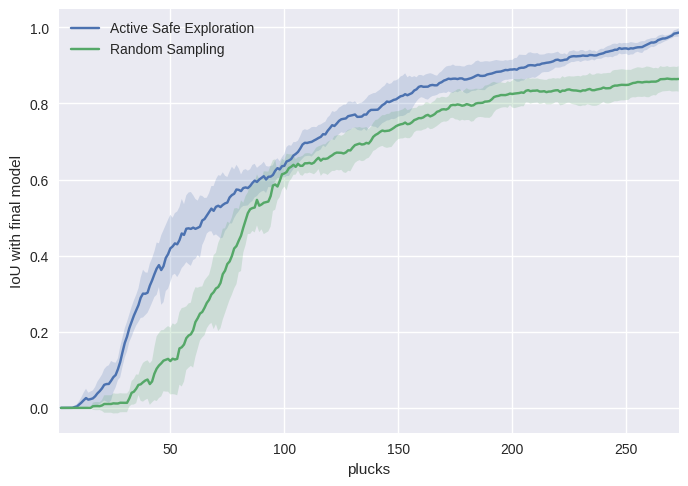

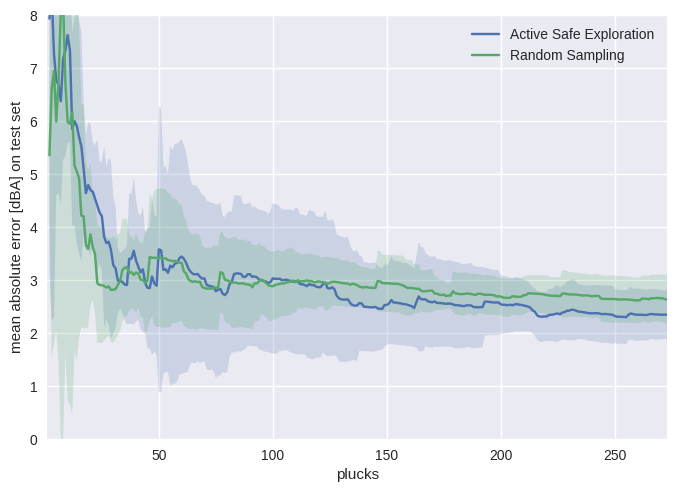

In [5]:
N = 273

# compute mean/std of iou over repetitions
mean_mae = pd.DataFrame()
std_mae = pd.DataFrame()
mean_random_mae = pd.DataFrame()
std_random_mae = pd.DataFrame()

for a in Analyses:
    mean_mae[a] = Analyses[a]['ASE']['Eval']['iou']
    std_mae[a] = Analyses[a]['ASE']['Eval']['iou']
    mean_random_mae[a] = Analyses[a]['Random']['Eval']['iou']
    std_random_mae[a] = Analyses[a]['Random']['Eval']['iou']

mean_mae = mean_mae.mean(axis=1).loc[:N]
std_mae = std_mae.std(axis=1).loc[:N]

mean_random_mae = mean_random_mae.mean(axis=1).loc[:N]
std_random_mae = std_random_mae.std(axis=1).loc[:N]

# plot mean with corridor of std
plt.figure()
mean_mae.rename('Active Safe Exploration').plot()
plt.fill_between(mean_mae.index, mean_mae-std_mae, mean_mae+std_mae, alpha=0.2)

mean_random_mae.rename('Random Sampling').plot()
plt.fill_between(mean_random_mae.index, mean_random_mae-std_random_mae, mean_random_mae+std_random_mae, alpha=0.2)

plt.legend();
plt.xlim(1, N)
plt.xlabel('plucks')
plt.ylabel('IoU with final model')
u.save_plot(f'iou of valid region {FOLDER_NAME} with p_safe {p_threshold_safe}')

# compute mean/std of mae over repetitions
mean_mae = pd.DataFrame()
std_mae = pd.DataFrame()
mean_random_mae = pd.DataFrame()
std_random_mae = pd.DataFrame()

for a in Analyses:
    mean_mae[a] = Analyses[a]['ASE']['Eval']['mae']
    std_mae[a] = Analyses[a]['ASE']['Eval']['mae']
    mean_random_mae[a] = Analyses[a]['Random']['Eval']['mae']
    std_random_mae[a] = Analyses[a]['Random']['Eval']['mae']

mean_mae = mean_mae.mean(axis=1)[:N]
std_mae = std_mae.std(axis=1)[:N]

mean_random_mae = mean_random_mae.mean(axis=1)[:N]
std_random_mae = std_random_mae.std(axis=1)[:N]

# plot mean with corridor of std
plt.figure()
mean_mae.rename('Active Safe Exploration').plot()
plt.fill_between(mean_mae.index, np.maximum(0, mean_mae-std_mae), mean_mae+std_mae, alpha=0.2)

mean_random_mae.rename('Random Sampling').plot()
plt.fill_between(mean_random_mae.index, np.maximum(0.0, mean_random_mae-std_random_mae), mean_random_mae+std_random_mae, alpha=0.2)
plt.xlim(1, N)
plt.xlabel('plucks')
plt.ylabel('mean absolute error [dBA] on test set')


plt.legend();
plt.ylim(0.0, 8.0)
u.save_plot(f'mae on test set {FOLDER_NAME}')